Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

<br/>

**IMPORT LIBRARIES AND DATASETS**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import plotly.graph_objects as go
import random

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras_preprocessing.image import ImageDataGenerator
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/Healthcare AI/Brain_MRI

/content/drive/My Drive/Colab Notebooks/Healthcare AI/Brain_MRI


In [4]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

<br/>
<br/>

# **Mask**
* The goal of image segmentation is to understand the image at the pixed level. It associates each pixel with a certain class. The output produce by image segmentation is called **`mask`** of the image.
* Masks can be represented by associating pixel values with their co-ordinates. For example if we have a black image of (2,2), this can be represented as: 
          [[0, 0],
          [0, 0]]

* To represent the mask we have to first flatten the image into a 1-D array.



In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head(10)

patient_id  ... mask
0  TCGA_CS_5395_19981004  ...    0
1  TCGA_CS_5395_19981004  ...    0
2  TCGA_CS_5395_19981004  ...    0
3  TCGA_CS_5395_19981004  ...    0
4  TCGA_CS_5395_19981004  ...    0
5  TCGA_CS_5395_19981004  ...    0
6  TCGA_CS_5395_19981004  ...    0
7  TCGA_CS_5395_19981004  ...    0
8  TCGA_CS_5395_19981004  ...    0
9  TCGA_CS_5395_19981004  ...    0

[10 rows x 4 columns]

In [7]:
brain_df.mask_path[1]   # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [8]:
brain_df.image_path[1]   # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [9]:
# 0 represents patient doesn't have brain tumor and 1 represents brain tumor
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

<br/>
<br/>

**PERFORM DATA VISUALIZATION**

In [10]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [11]:
fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0, 200, 0)', marker_line_color = 'rgb(255, 0, 0)',
                  marker_line_width = 2, opacity = 0.6)
fig.show()

In [12]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [13]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

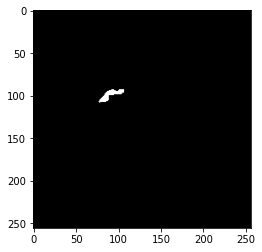

In [14]:
# check random image
plt.imshow(cv2.imread(brain_df.mask_path[623]))

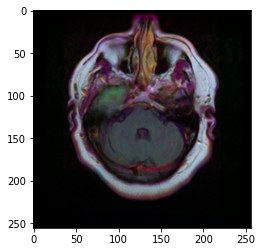

In [15]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [16]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [17]:
cv2.imread(brain_df.mask_path[623]).min()

0

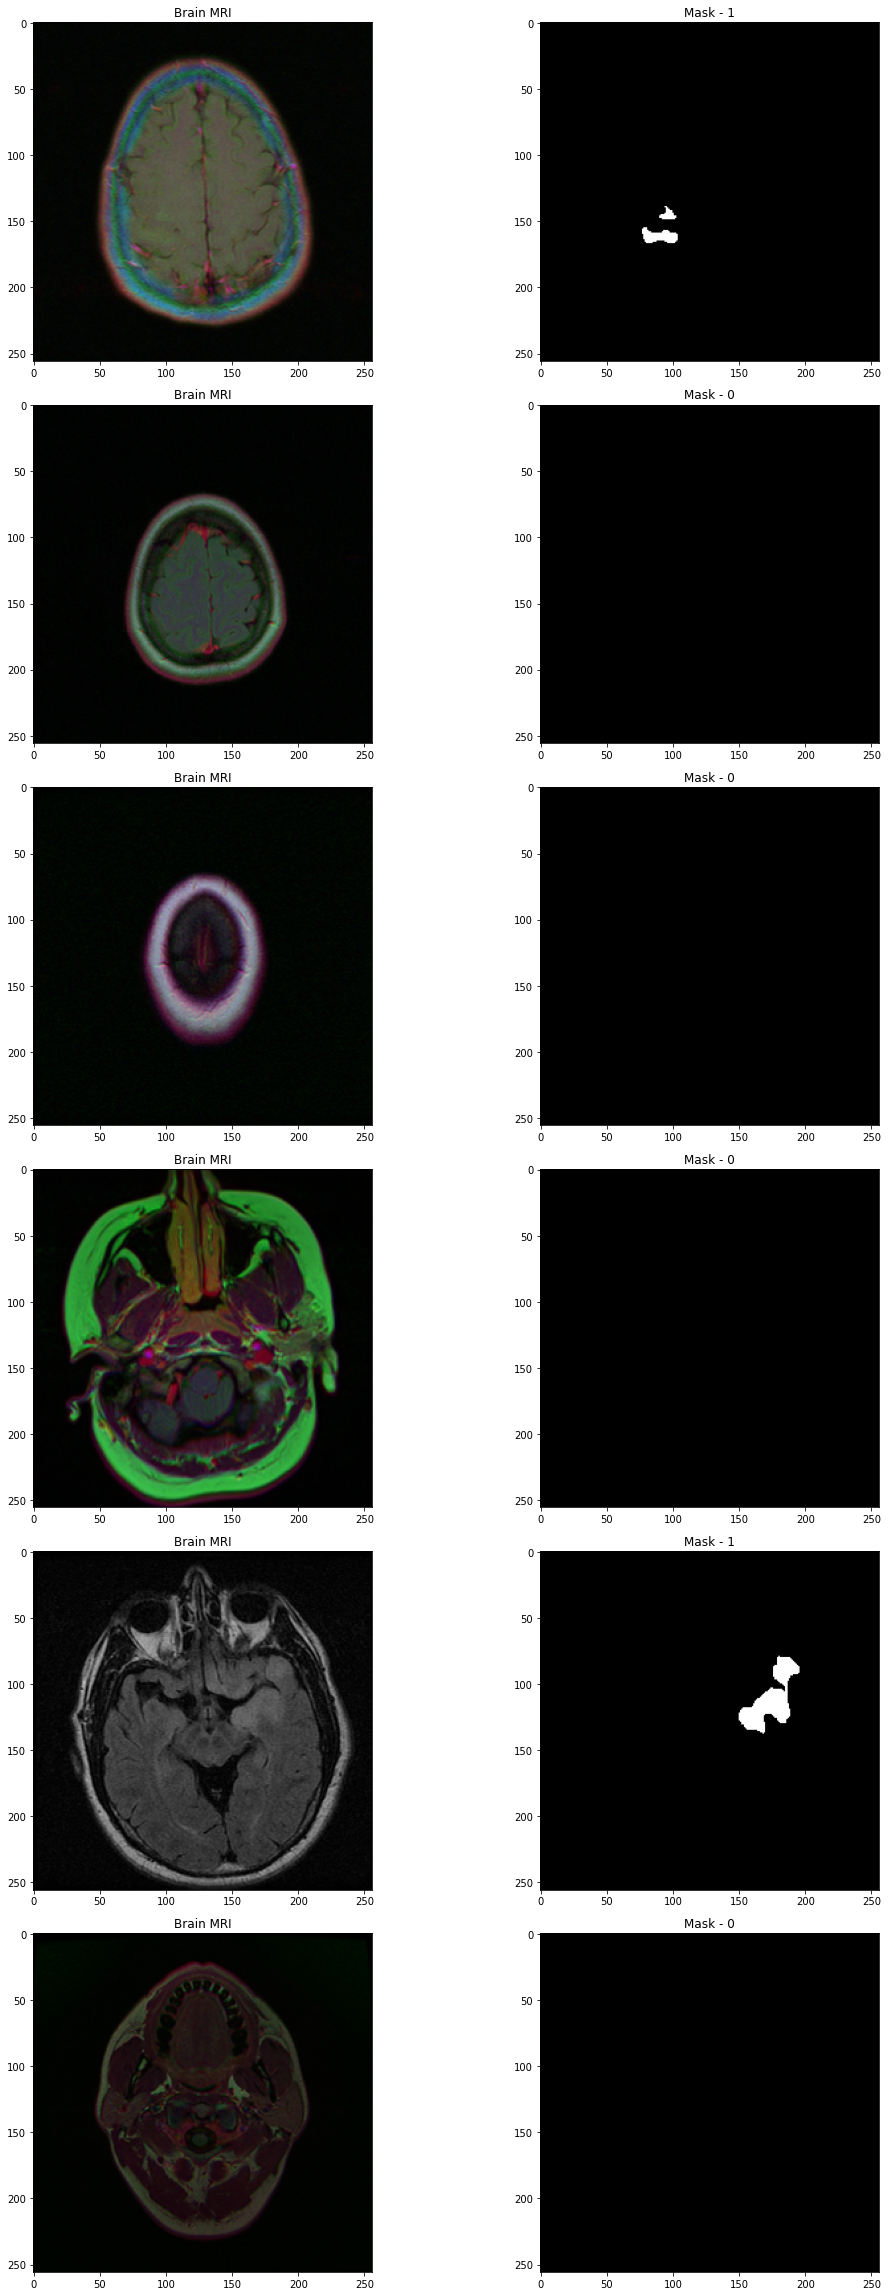

In [18]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately
fig, axes = plt.subplots(6, 2, figsize=(16, 32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axes[count][0].title.set_text('Brain MRI') # set title
  axes[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axes[count][1].title.set_text('Mask - ' + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axes[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

<br/>
<br/>

Plot 12 randomly selected (1) MRI scan images from only sick patients followed by (2) corresponding mask, (3) both MRI image and the corresponding mask (in red color) on top of each other

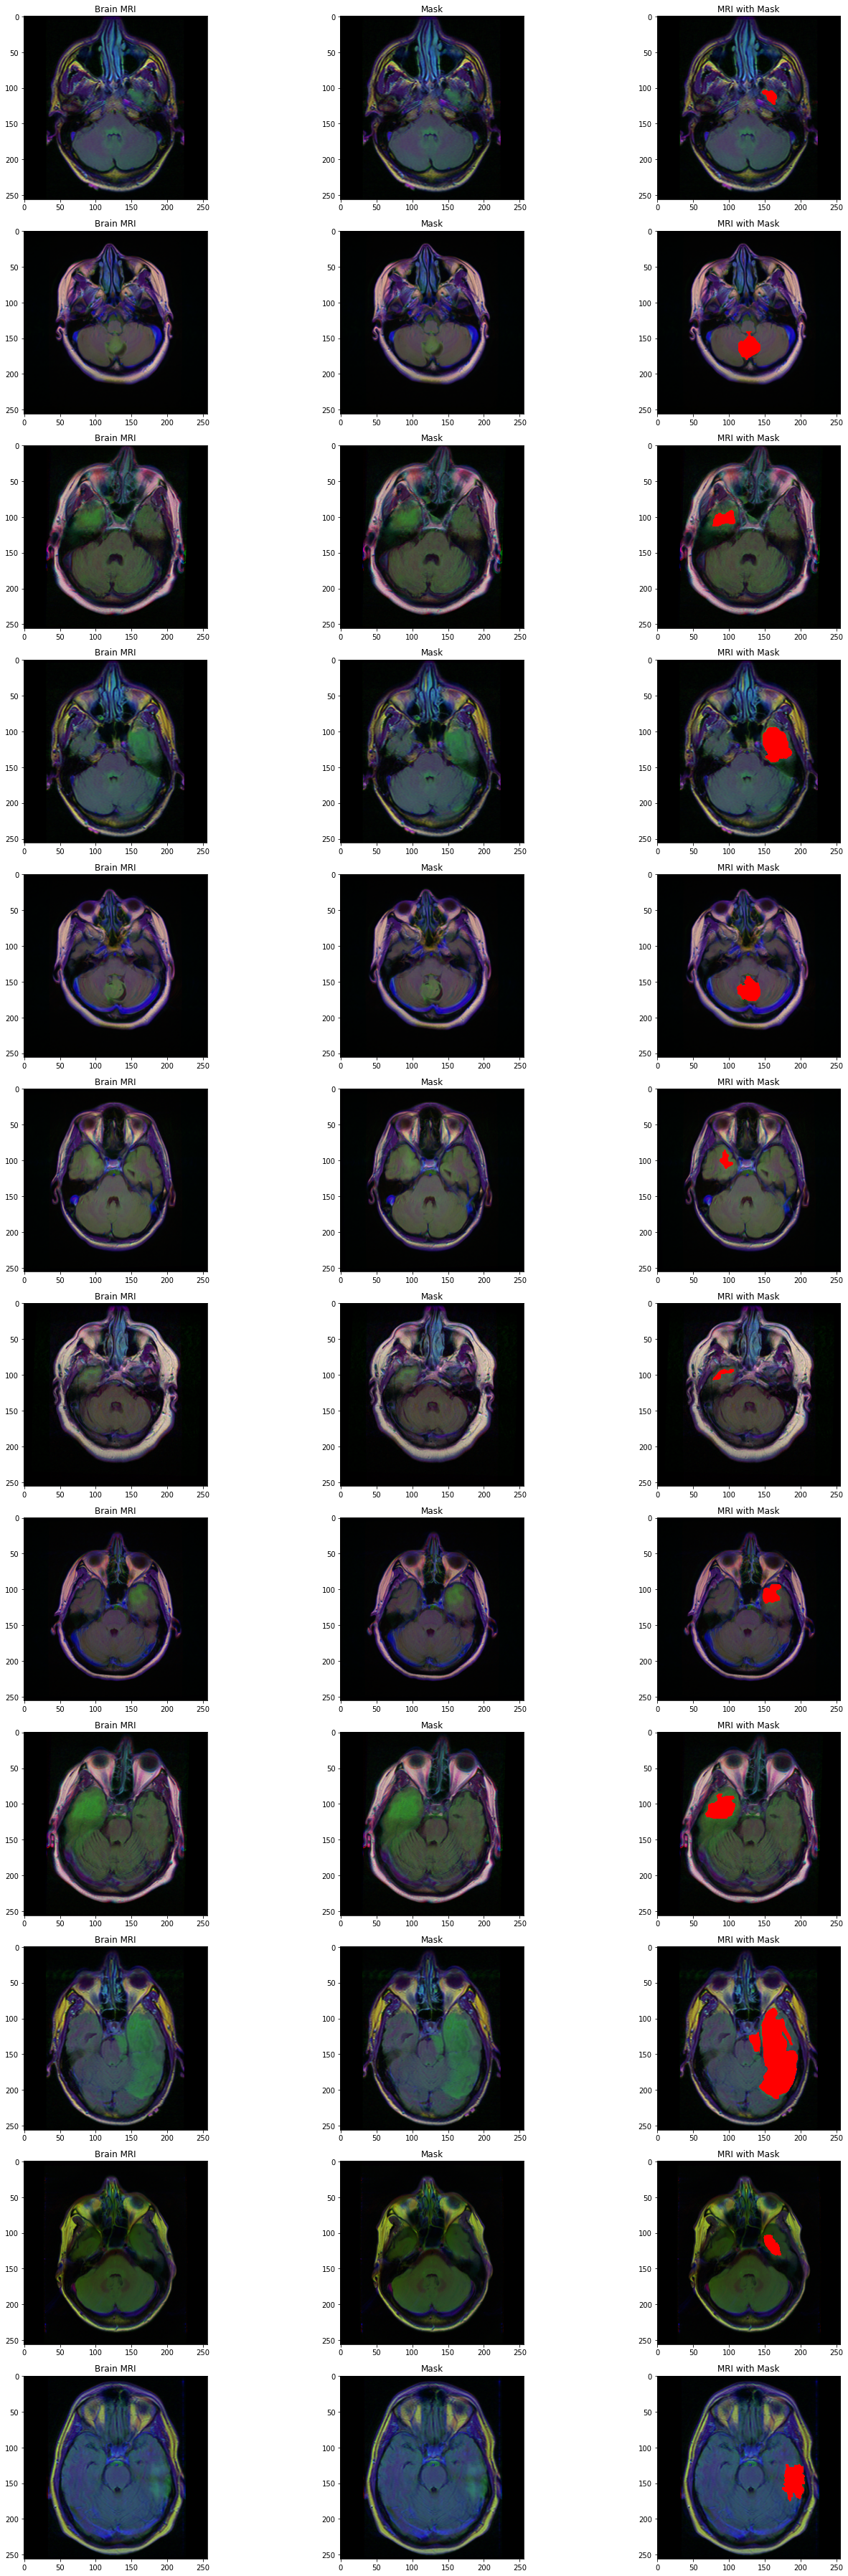

In [19]:
count = 0
fig, axes = plt.subplots(12, 3, figsize=(20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axes[count][0].title.set_text('Brain MRI')
    axes[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axes[count][1].title.set_text('Mask')
    axes[count][1].imshow(img, cmap='gray')

    img[mask == 255] = (255, 0, 0)
    axes[count][2].title.set_text('MRI with Mask')
    axes[count][2].imshow(img)

    count += 1

fig.tight_layout()

<br/>
<br/>

- Feature Extraction and Convolutions: https://setosa.io/ev/image-kernels/
- CNN Visualization: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html


- Link to ResNet paper entitled (Deep Residual Learning for Image Recognition): https://arxiv.org/pdf/1512.03385.pdf
- Excellent Resource on transfer learning by Dipanjan Sarkar: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
- Article by Jason Brownlee: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

<br/>
<br/>

# Train a Classifier Model to detect if Tumor exists or not

In [20]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns=['patient_id'])
brain_df_train.shape

(3929, 3)

In [21]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [22]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [23]:
# split the data into train and test

train, test = train_test_split(brain_df_train, test_size=0.15)

In [24]:
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15

datagen = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.15
)

In [25]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(256, 256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='validation',
    shuffle=True,
    class_mode='categorical',
    target_size=(256, 256)
)

# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [26]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [27]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [29]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
# headmodel = Dense(256, activation='relu')(headmodel)
# headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)

In [30]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [31]:
# compile the model

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
# use EarlyStopping to exit training if validation loss is not decreasing even after certain epochs

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath='classifier-resnet-weights.hdf5', verbose=1, save_best_only=True)

In [33]:
# training model for only 1 epoch (taking lot of time to train the model)
history = model.fit(train_generator, steps_per_epoch=train_generator.n // 16, epochs=1, validation_data=valid_generator,
                    validation_steps=valid_generator.n // 16, callbacks=[checkpointer, earlyStopping])

177/177 [==============================] - ETA: 0s - loss: 0.7802 - accuracy: 0.7099WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 31 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 5.01653, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 47s 264ms/step - loss: 0.7802 - accuracy: 0.7099 - val_loss: 5.0165 - val_accuracy: 0.6920


In [34]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open('classifier-resnet-model.json', 'w') as json_file:
  json_file.write(model_json)

<br/>
<br/>

# ASSESS TRAINED MODEL PERFORMANCE

In [35]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
  json_savedModel = json_file.read()

# load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [36]:
# make prediction

test_predict = model.predict(test_generator, steps=test_generator.n // 16, verbose=1)

36/36 [==============================] - 2s 69ms/step


In [37]:
test_predict.shape

(576, 2)

In [38]:
test_predict

array([[9.9995542e-01, 4.4631419e-05],
       [9.9997962e-01, 2.0424759e-05],
       [9.9990559e-01, 9.4441275e-05],
       ...,
       [1.5702473e-06, 9.9999845e-01],
       [1.0000000e+00, 8.8158654e-09],
       [1.0000000e+00, 1.0271641e-08]], dtype=float32)

In [39]:
# obtain the predicted class from the model prediction

predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [40]:
predict

array(['0', '0', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1',
       '1', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0',
       '0', '1', '1', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0',
       '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1',
       '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0',
       '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1',
       '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '0', '0',
       '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1

In [41]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [42]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9878472222222222

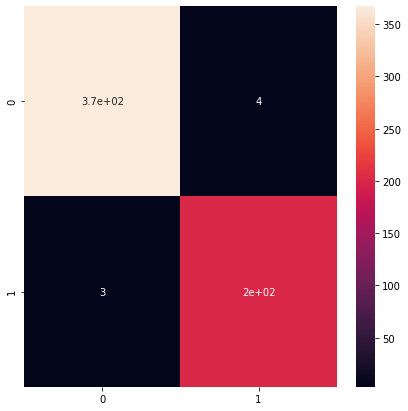

In [43]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True)

In [44]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       371
           1       0.98      0.99      0.98       205

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:565: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<br/>
<br/>

# BUILD A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [45]:
# Get the dataframe containing MRIs which have masks associated with them

brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [46]:
# split the data into train and test data

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [47]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [48]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [49]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [50]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [51]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [52]:
model_seg.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
_______________________________________________________________________________________

<br/>
<br/>

# TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE TUMOR

<br/>

**Loss Function**

WNeed a custom loss function to train this ResUNet.Have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

[A Novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation](https://arxiv.org/abs/1810.07842)

In [53]:
from utilities import focal_tversky, tversky_loss, tversky

In [54]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [55]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [57]:
history = model_seg.fit(training_generator, epochs = 20, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.5532 - tversky: 0.5406
Epoch 00001: val_loss improved from inf to 0.56673, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 58s 802ms/step - loss: 0.5532 - tversky: 0.5406 - val_loss: 0.5667 - val_tversky: 0.5285
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.3905 - tversky: 0.7124
Epoch 00002: val_loss improved from 0.56673 to 0.36854, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 17s 240ms/step - loss: 0.3905 - tversky: 0.7124 - val_loss: 0.3685 - val_tversky: 0.7351
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.3586 - tversky: 0.7435
Epoch 00003: val_loss did not improve from 0.36854
72/72 [==============================] - 14s 190ms/step - loss: 0.3586 - tversky: 0.7435 - val_loss: 0.4487 - val_tversky: 0.6560
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.2968 - tversky: 0.8008
Epoch

In [58]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

<br/>
<br/>

# Assess Trained Segmentation RESUNET Model Performance

In [60]:
# using pretrained model

with open('ResUNet-MRI.json', 'r') as json_file:
  json_savedModel = json_file.read()

# load model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1)
model_seg.compile(optimizer=adam, loss=focal_tversky, metrics=[tversky])

In [61]:
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [62]:
# creating a dataframe for the result

df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  ... has_mask
0    TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_26...  ...        0
1    TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_15...  ...        0
2    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_14...  ...        0
3    TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_28...  ...        0
4    TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16...  ...        1
..                                                 ...  ...      ...
585  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_31...  ...        1
586  TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_25...  ...        0
587  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_32...  ...        0
588  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_36...  ...        0
589  TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_55...  ...        0

[590 rows x 3 columns]

In [63]:
# Merge the dataframe containing predicted results with the original test data.

df_pred = test.merge(df_pred, on='image_path')
df_pred.head()

image_path  ... has_mask
0  TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_26...  ...        0
1  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_15...  ...        0
2  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_14...  ...        0
3  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_28...  ...        0
4  TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_16...  ...        1

[5 rows x 5 columns]

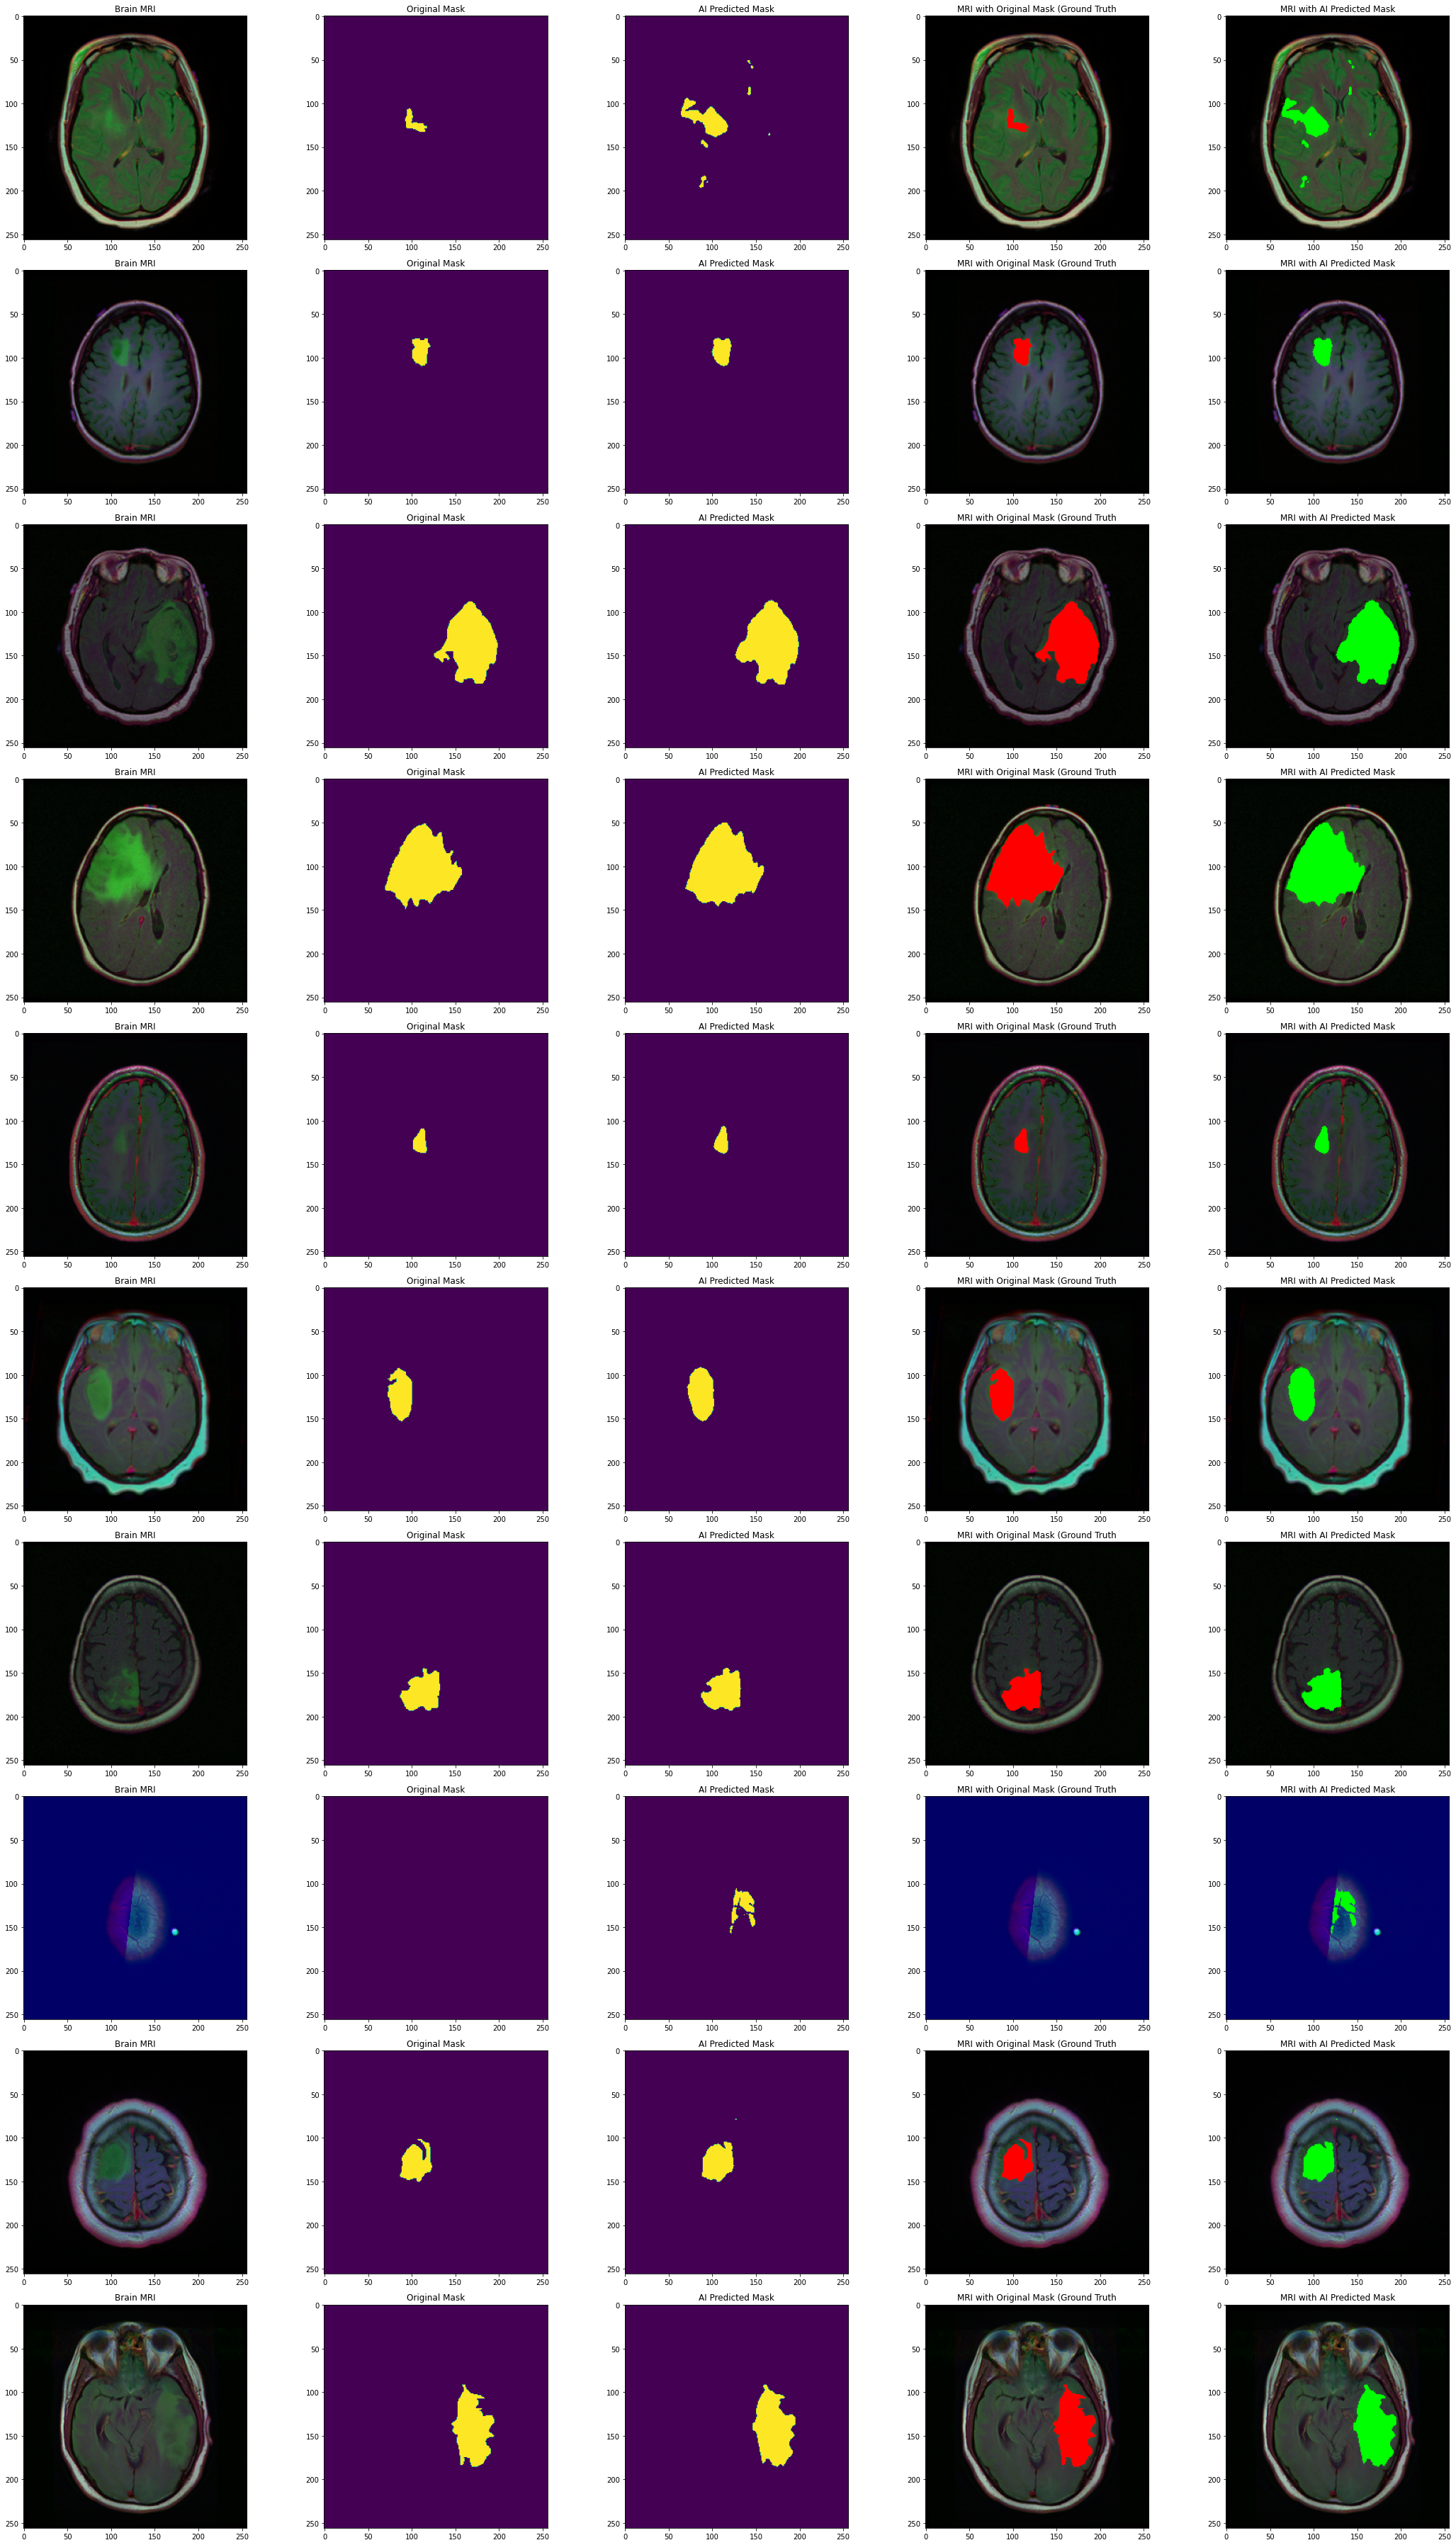

In [64]:
count = 0
fig, axes = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[count][0].title.set_text('Brain MRI')
    axes[count][0].imshow(img)

    # obtain the mask of the image
    mask = io.imread(df_pred.mask_path[i])
    axes[count][1].title.set_text('Original Mask')
    axes[count][1].imshow(mask)

    # obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axes[count][2].title.set_text('AI Predicted Mask')
    axes[count][2].imshow(predicted_mask)

    # apply the mask to the image 'mask=255'
    img[mask == 255] = (255, 0, 0)
    axes[count][3].title.set_text('MRI with Original Mask (Ground Truth')
    axes[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axes[count][4].title.set_text('MRI with AI Predicted Mask')
    axes[count][4].imshow(img_)

    count += 1

fig.tight_layout()